In [41]:
import tensorflow as tf
import json
import numpy as np
import pandas as pd

from google.cloud import bigquery
from google.cloud import storage

# from google.cloud import aiplatform


import matplotlib.pyplot as plt
import seaborn as sns
#https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/custom/custom-tabular-bq-managed-dataset.ipynb

In [42]:
print(tf.__version__)

2.11.0


In [43]:
#table_id='new_incident'
table_id='test_incident'
# table_id='validation_incident'

isLocalModel=True
isBQToCSV=True
localFile=True


modelFile_endPoint=1 
#1=local(dev)/gcs(clound function) and 2=vertext

projectId='smart-data-ml'
dataset_id='SMartML'
REGION="asia-southeast1"

if  table_id=='new_incident':
 unUsedColtoPredict=['severity','id','severity_id','severity_name','imported_at']
 filePath='../../data/Prediction_New_Incident.csv'
elif table_id=='test_incident' or table_id=='validation_incident':
 unUsedColtoPredict=['severity','id','severity_id','severity_name']  
 filePath=f'../../data/Prediction_{table_id}.csv'


In [44]:
from google.oauth2 import service_account
mycredentials = service_account.Credentials.from_service_account_file(r'C:\Windows\smart-data-ml-91b6f6204773.json')

if isBQToCSV:
    
    
    bqclient= bigquery.Client(project=projectId,credentials=mycredentials)
    def download_table(bq_table_uri: str):

        prefix = "bq://"
        if bq_table_uri.startswith(prefix):
            bq_table_uri = bq_table_uri[len(prefix) :]

        table = bigquery.TableReference.from_string(bq_table_uri)
        rows = bqclient.list_rows(table)
        return rows.to_dataframe()

    dfNewData=download_table(f"{projectId}.{dataset_id}.{table_id}")
    dfNewData.to_csv(filePath,index=False)    
    print(dfNewData.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278 entries, 0 to 277
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   severity_id                278 non-null    Int64  
 1   severity_name              278 non-null    object 
 2   sla                        278 non-null    object 
 3   product_type               278 non-null    object 
 4   brand                      278 non-null    object 
 5   service_type               278 non-null    object 
 6   incident_type              278 non-null    object 
 7   open_to_close_hour         278 non-null    float64
 8   response_to_resolved_hour  278 non-null    float64
 9   label_multi_severity       278 non-null    Int64  
 10  label_binary_severity      278 non-null    Int64  
dtypes: Int64(3), float64(2), object(6)
memory usage: 24.8+ KB
None



# Load and Map Data Test

In [45]:
if  localFile:
    print("Load local file")
    dfNewData=pd.read_csv(filePath)

# dfNewData=dfNewData.sample(3)

Load local file


In [46]:
mapping_file="incident_severity_to_class.json"

def download_map_severity_class_as_dict():
 
    storage_client = storage.Client()
    buckdfNewData = storage_client.bucket("smart-ml-pongthorn")
    blob = bucket.blob(mapping_file)
    blob.download_to_filename(mapping_file)
    with open(mapping_file, 'r') as file:
            return json.loads(file.read())

if  localFile==False:    
    map_sevirity_to_class= download_map_severity_class_as_dict()
else:
   with open(mapping_file, 'r') as json_file:
     map_sevirity_to_class= json.load(json_file)
                                  
                                  
print(map_sevirity_to_class)


{'Cosmetic': 0, 'Minor': 1, 'Major': 2, 'Critical': 3}


In [47]:
if table_id=='new_incident':
    
    dfNewData.insert(2, 'severity', dfNewData['severity_name'].map(map_sevirity_to_class),True)
    print(dfNewData.info())
elif table_id=='test_incident' or table_id=='validation_incident':
    
    dfNewData=dfNewData.rename(columns={'label_multi_severity':'severity'})
    dfNewData=dfNewData.drop(columns=['label_binary_severity'])
    if 'id' not in dfNewData.columns.to_list():
        dfNewData=dfNewData.reset_index(drop=True)
        dfNewData = dfNewData.reset_index(level=0)
        dfNewData.rename(columns={"index": "id"},inplace=True)
        dfNewData['id']=dfNewData['id']+1
print(filePath) 
print(dfNewData.info())
dfNewData.tail()

../../data/Prediction_test_incident.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278 entries, 0 to 277
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         278 non-null    int64  
 1   severity_id                278 non-null    int64  
 2   severity_name              278 non-null    object 
 3   sla                        278 non-null    object 
 4   product_type               278 non-null    object 
 5   brand                      278 non-null    object 
 6   service_type               278 non-null    object 
 7   incident_type              278 non-null    object 
 8   open_to_close_hour         278 non-null    float64
 9   response_to_resolved_hour  278 non-null    float64
 10  severity                   278 non-null    int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 24.0+ KB
None


,id,severity_id,severity_name,sla,product_type,brand,service_type,incident_type,open_to_close_hour,response_to_resolved_hour,severity
273,274,3,Minor,24x7 4Hrs Response Time,Software,Trend Micro,Incident,General Incident,3.850000,2.183333,1
274,275,3,Minor,24x7 4Hrs Response Time,Software,Trend Micro,Request,Software,0.650000,0.466667,1
275,276,4,Cosmetic,24x7 4Hrs Response Time,Software,Trend Micro,Request,General Incident,24.366667,22.050000,0
276,277,4,Cosmetic,24x7 4Hrs Response Time,Software,Trend Micro,Request,General Incident,168.150000,164.666667,0
277,278,4,Cosmetic,24x7 4Hrs Response Time,Security,Trend Micro,Request,OS / Firmware,16.666667,16.666667,0


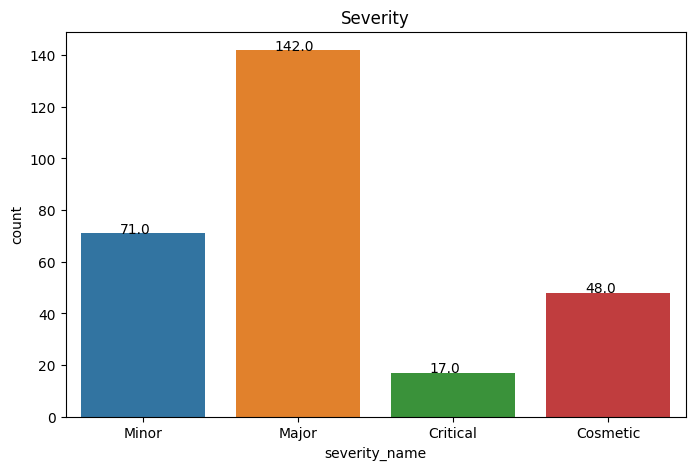

In [49]:
def plot_class(df):
    fig , ax = plt.subplots(figsize=(8,5))
    ax =sns.countplot(x='severity_name', data=df,)
    for p in ax.patches:
       ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
    plt.title('Severity')
    plt.show()
    
plot_class(dfNewData)

In [50]:
pdPrediction=pd.DataFrame(columns=['_id','_predict_severity'])
pdPrediction

,_id,_predict_severity


# Load Model from Directory to Predict

In [51]:
if modelFile_endPoint==1 :

    if  isLocalModel: # Window Enviroment
        PATH_FOLDER_ARTIFACTS="model"    
    else: # For running on Vertex AI Notebook t
        PATH_FOLDER_ARTIFACTS="gs://tf1-incident-pongthorn/model"

    model = tf.keras.models.load_model(PATH_FOLDER_ARTIFACTS)    
    print(f"Load from {PATH_FOLDER_ARTIFACTS}")
    # model.summary()

    
    for  row_dict in dfNewData.to_dict(orient="records"):
          incident_id=row_dict['id']
          print(f"{incident_id} - {row_dict['severity']}({row_dict['severity_name']})") 
          for key_removed in unUsedColtoPredict:
           row_dict.pop(key_removed)
          # print(row_dict)  

          input_dict = {name: tf.convert_to_tensor([value]) for name, value in row_dict.items()}


          predictionResult = model.predict(input_dict)
          # print(f"{predictionResult}")   
          # maxResult=np.max(arryResult)
          # maxResult=round( maxResult,4)
          # print(f"{maxResult} of {arryResult}")

          prob = tf.nn.softmax(predictionResult)
          prob_pct=(100 * prob)  
          _class = tf.argmax(predictionResult,-1).numpy()[0]
          
          pdPrediction =pd.concat([pdPrediction,pd.DataFrame.from_dict([{'_id':incident_id, '_predict_severity':_class}])] )
          # print(input_dict)  
            
          print(f"{prob_pct} %   as {_class}")     
          print("======================================================================================")

    dfPredictData=pd.merge(dfNewData,pdPrediction,how='inner',left_on='id',right_on='_id')
    dfPredictData=dfPredictData.drop(columns=['_id'])
    dfPredictData=dfPredictData[['id','_predict_severity','severity','severity_name']]


Load from model
1 - 1(Minor)
1/1 [==============================] - 1s 555ms/step
[[19.511103 35.99466  24.999838 19.494404]] %   as 1
2 - 2(Major)
1/1 [==============================] - 0s 41ms/step
[[18.953287 26.77774  35.39178  18.877184]] %   as 2
3 - 2(Major)
1/1 [==============================] - 0s 41ms/step
[[18.954182 26.863974 35.29893  18.882914]] %   as 2
4 - 2(Major)
1/1 [==============================] - 0s 58ms/step
[[18.960423 26.921284 35.23285  18.885437]] %   as 2
5 - 1(Minor)
1/1 [==============================] - 0s 57ms/step
[[18.95377  26.785282 35.38323  18.877728]] %   as 2
6 - 3(Critical)
1/1 [==============================] - 0s 45ms/step
[[19.353865 24.011942 35.834652 20.799543]] %   as 2
7 - 3(Critical)
1/1 [==============================] - 0s 62ms/step
[[18.296717 19.679571 42.36902  19.654696]] %   as 2
8 - 3(Critical)
1/1 [==============================] - 0s 55ms/step
[[19.433823 24.077745 28.330606 28.157827]] %   as 2
9 - 3(Critical)
1/1 [=========

# Registry and Deploy Model to VertextAI
- https://cloud.google.com/vertex-ai/docs/predictions/get-predictions#deploy_a_model_to_an_endpoint


## Load Model from Online EndPpint to Predict
- https://cloud.google.com/vertex-ai/docs/tabular-data/classification-regression/get-online-predictions
- https://cloud.google.com/vertex-ai/docs/tutorials/tabular-bq-prediction/train-and-deploy-model
- https://cloud.google.com/vertex-ai/docs/tutorials/tabular-bq-prediction/make-prediction

In [52]:
#https://console.cloud.google.com/vertex-ai/endpoints?project=pongthorn
#https://console.cloud.google.com/vertex-ai/batch-predictions?project=pongthorn


# MODEL_ID="2102389377610022912"
# MODEL_URI =  f'projects/{PROJECT_NUMBER}/locations/{REGION}/models/{MODEL_ID}'
# print(MODEL_URI)

# model = aiplatform.Model(MODEL_URI)

# Load model by refering to vertext-ai registry

In [53]:
# instances = []
# dfX=dfNewData.drop(columns=unUsedColtoPredict)
# for index,row in dfX.iterrows():
#     dict_item=row.to_dict()
#     instance = {}
#     for key, value in dict_item.items():
#         if key in unUsedColtoPredict:
#             continue
#         if value is None:
#             value = ""
#         instance[key] = [value]
#         # instance[key] = value
#     instances.append(instance)

# print(len(instances))
# print(instances[0])

In [54]:
isEndpointAvaiable=False

listRequestData=[]
try:
    ENDPOINT_ID="2704182877817405440"
    endpoint = aiplatform.Endpoint(endpoint_name=f"projects/{projectId}/locations/{REGION}/endpoints/{ENDPOINT_ID}"
                                   ,credentials=mycredentials)
    print(endpoint)
    isEndpointAvaiable=True
except Exception as error:
    print(str(error))
    
if modelFile_endPoint==2 and isEndpointAvaiable==True :

    for data in dfNewData.to_dict(orient="records"):
        incident_id=data['id']
        severity=data['severity']
        severity_name=data['severity_name']
        # convert dict to tf format
        request_data = {key : [value] for key,value in data.items() }
        for key_removed in unUsedColtoPredict:
           request_data.pop(key_removed)
        listRequestData.append(request_data)
        print(request_data)

        response = endpoint.predict([request_data])
        y_predicted = np.argmax(response.predictions, axis=1)
        predictionResult=response[0][0]
        print(predictionResult)
        print(y_predicted)

        pdPrediction =pd.concat([pdPrediction,pd.DataFrame.from_dict([{'_id':incident_id, '_predict_severity':y_predicted[0]}])] )
        print("======================================================================================")

    dfPredictData=pd.merge(dfNewData,pdPrediction,how='inner',left_on='id',right_on='_id')
    dfPredictData=dfPredictData.drop(columns=['_id'])
    dfPredictData=dfPredictData[['id','_predict_severity','severity','severity_name']]       
else:
     print("No endpoint to predict  as online predction")     

name 'aiplatform' is not defined
No endpoint to predict  as online predction


# Classification Rerport

In [55]:
from sklearn.metrics import confusion_matrix,classification_report


In [56]:
dfPredictData

,id,_predict_severity,severity,severity_name
0,1,1,1,Minor
1,2,2,2,Major
2,3,2,2,Major
3,4,2,2,Major
4,5,2,1,Minor
...,...,...,...,...
273,274,1,1,Minor
274,275,1,1,Minor
275,276,0,0,Cosmetic
276,277,0,0,Cosmetic


In [58]:
className=list(set().union(list(dfPredictData['severity'].unique()),list(dfPredictData['_predict_severity'].unique())))
actualClass=[  f'actual-{x}' for x in  className]
predictedlClass=[  f'predcited-{x}' for x in className]

y_true=list(dfPredictData['severity'])
y_pred=list(dfPredictData['_predict_severity'])
cnf_matrix = confusion_matrix(y_true,y_pred)
cnf_matrix

# #index=actual , column=prediction
cm_df = pd.DataFrame(cnf_matrix,
                     index = actualClass, 
                     columns = predictedlClass)
cm_df

,predcited-0,predcited-1,predcited-2,predcited-3
actual-0,38,6,4,0
actual-1,3,48,20,0
actual-2,4,27,111,0
actual-3,1,1,14,1


In [59]:
print(classification_report(y_true, y_pred, labels=className))

              precision    recall  f1-score   support

           0       0.83      0.79      0.81        48
           1       0.59      0.68      0.63        71
           2       0.74      0.78      0.76       142
           3       1.00      0.06      0.11        17

    accuracy                           0.71       278
   macro avg       0.79      0.58      0.58       278
weighted avg       0.73      0.71      0.70       278

